In [1]:
# Install required libraries
# pip install pyod networkx python-louvain pandas

import pandas as pd
import numpy as np
import os
import networkx as nx
import community
import matplotlib.pyplot as plt

from pyod.models.cblof import CBLOF
from sklearn.preprocessing import LabelEncoder

In [4]:
data_folder = '/home/sunilkarki/Documents/Persn/CProj/bnp/data'

file_path = os.path.join(data_folder, 'transactions1.csv')
blockchain_data = pd.read_csv(file_path)

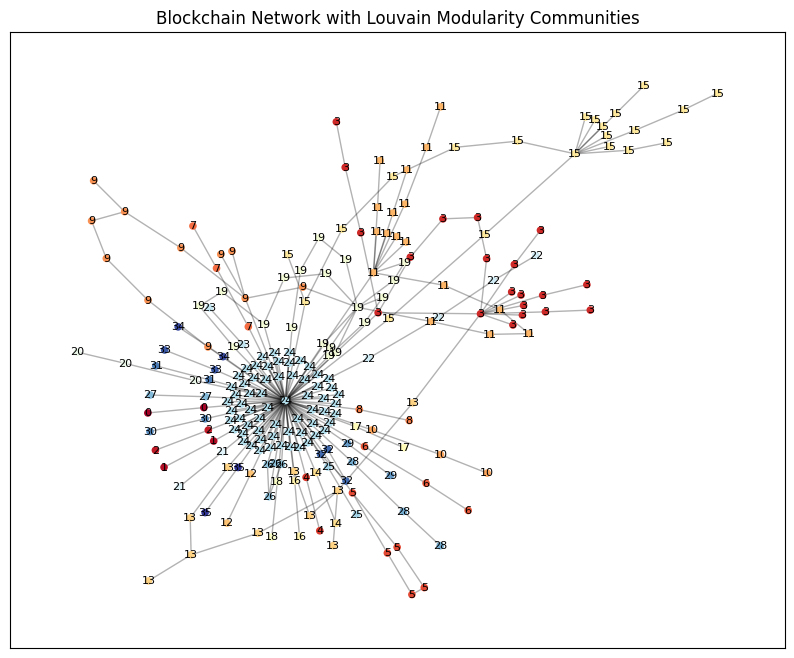

/home/sunilkarki/Documents/Persn/CProj/bnp/virtualenvs/.py3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Block Number,Transaction Hash,From,To,Value (ETH),Timestamp,Community,Anomaly
0,17140930,0xa7af6f90a8cd6a7d5279a050af0f43061194632d9021...,80,52,0.1500,1682640023,15,0
1,17140930,0xcc784b110da9733eff91a98317c69120a90895ee8f5e...,174,54,0.2500,1682640023,1,0
2,17140930,0xdeca1a9a4b3d9b455fa8fc8b1983ba35cb49cdb4d4fd...,211,87,1.4924,1682640023,2,1
3,17140930,0x3d5753ff616de541fd04be5b9d1394cae7f498b20ee6...,88,42,0.0421,1682640023,3,0
4,17140930,0x2bcbbdecb2a8728a840cbe30d11373cc816dc9e7030c...,107,14,1.3592,1682640023,19,0
...,...,...,...,...,...,...,...,...
245,17140930,0xa006b808a421a136a6256bc425a0f45aab5f55749407...,193,38,0.0220,1682640023,25,0
246,17140930,0x0c92e1377a45bb98e3d3fe0f7f2632f1a90d8f297c97...,166,56,0.0145,1682640023,16,0
247,17140930,0x7a79d81b7f3fcccbf2b3937930eacd2658eba0a2e46a...,37,86,0.0300,1682640023,11,0
248,17140930,0x3e3e43e746a7a23c0547e987d2ea3c1875987422f4c0...,226,35,0.1500,1682640023,3,0


In [5]:

# Load your blockchain data into a DataFrame (replace 'your_data.csv' with your actual file name or data source)
# blockchain_data = pd.read_csv('your_data.csv')

# Convert hex values to label encoded numeric values
label_encoder = LabelEncoder()

blockchain_data['From'] = label_encoder.fit_transform(blockchain_data['From'])
blockchain_data['To'] = label_encoder.fit_transform(blockchain_data['To'])

blockchain_data['Value (ETH)'] = pd.to_numeric(blockchain_data['Value (ETH)'], errors='coerce')
# blockchain_data['Value (ETH)'] = blockchain_data['Value (ETH)'].div(1000000000000000000).round(4)
blockchain_data['Value (ETH)'] = (blockchain_data['Value (ETH)'] / 1000000000000000000).round(4)

# Select relevant columns for the analysis
selected_columns = ['From', 'To', 'Value (ETH)']
selected_data = blockchain_data[selected_columns]

# Create a directed graph from the blockchain data
G = nx.from_pandas_edgelist(selected_data, 'From', 'To', ['Value (ETH)'], create_using=nx.Graph())

# Louvain Modularity for Community Detection
partition = community.best_partition(G)

# Add the community information to the blockchain data
blockchain_data['Community'] = blockchain_data['From'].map(partition)

# Visualize the network graph with communities
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Draw community labels
nx.draw_networkx_labels(G, pos, labels=partition, font_size=8)

plt.title("Blockchain Network with Louvain Modularity Communities")
plt.show()

# CBLOF for Anomaly Detection
X = selected_data.values

# Normalize the 'Value (ETH)' column to ensure a consistent scale for CBLOF
# X[:, -1] = (X[:, -1] - X[:, -1].min()) / (X[:, -1].max() - X[:, -1].min())

# Train CBLOF model
cblof_model = CBLOF()
cblof_model.fit(X)

# Predict outliers
outliers = cblof_model.predict(X)

# Add anomaly information to the blockchain data
blockchain_data['Anomaly'] = outliers

# Display the blockchain data with community and anomaly information
blockchain_data


In [48]:
anomaly_data = blockchain_data[blockchain_data['Anomaly'] != 0]

# Display the filtered data
anomaly_data

,Block Number,Transaction Hash,From,To,Value (ETH),Timestamp,Community,Anomaly
2,17140930,0xdeca1a9a4b3d9b455fa8fc8b1983ba35cb49cdb4d4fd...,211,87,1.4924,1682640023,2,1
13,17140930,0xa8e815082279e310e03ee52c553c972dcf76b37d6ba7...,177,83,0.0072,1682640023,12,1
16,17140930,0xdceee6db33d7d351f06b15bb8a8e848693634706553f...,6,63,0.7651,1682640023,3,1
18,17140930,0xf3854cce81b1f37e912209b5b03ae39997c9d79b5495...,225,63,0.4656,1682640023,3,1
25,17140930,0x905a2bd252a032ad146b383f6ca6b682cb272b64361b...,190,86,0.1500,1682640023,29,1
35,17140930,0x596c2184c75d8b14f7fc93cc3a9025c33f3499ee083d...,216,106,0.0425,1682640023,16,1
36,17140930,0xd19ff5229107019c63fc89665b8d0b7b5dbd4c1debbd...,171,49,30.9761,1682640023,17,1
44,17140930,0x230f6d0b2f230298eb707d2f8b38f3b8cc1e5565f848...,170,77,0.3760,1682640023,20,1
51,17140930,0xc17335c921b1bf5e1bb16dabda8f5fadc0a642e83c04...,186,86,0.0800,1682640023,29,1
105,17140930,0xed23182104a6572c69e9587cf3e1a0690df558eed594...,229,95,0.0508,1682640023,30,1


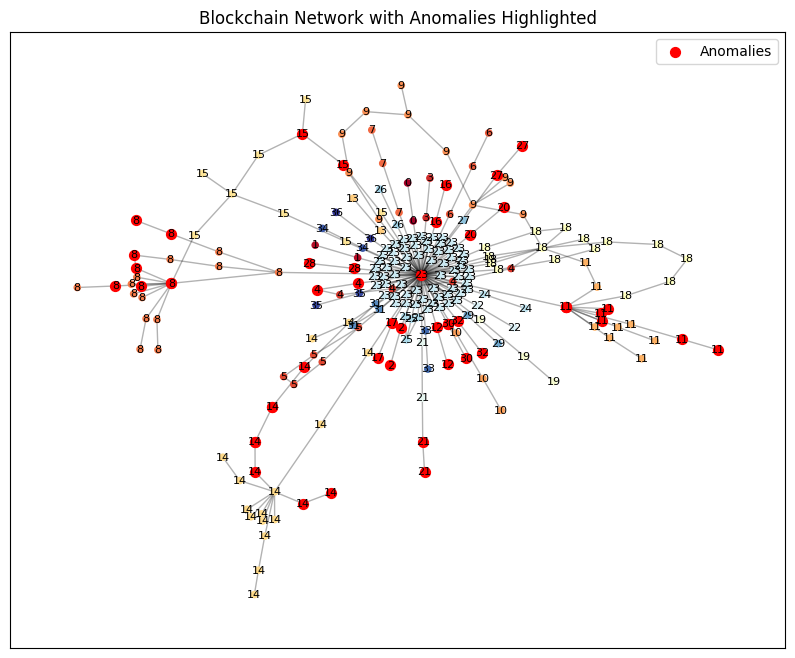

In [6]:
import pandas as pd
import numpy as np
from pyod.models.cblof import CBLOF
import networkx as nx
import community
import matplotlib.pyplot as plt

# Assuming 'Anomaly' is the name of the column indicating anomalies
anomaly_data = blockchain_data[blockchain_data['Anomaly'] != 0]

# Create a directed graph from the blockchain data
G = nx.from_pandas_edgelist(selected_data, 'From', 'To', ['Value (ETH)'], create_using=nx.Graph())

# Louvain Modularity for Community Detection
partition = community.best_partition(G)

# Add the community information to the blockchain data
blockchain_data['Community'] = blockchain_data['From'].map(partition)

# Visualize the network graph with communities
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Draw community labels
nx.draw_networkx_labels(G, pos, labels=partition, font_size=8)

# Highlight anomalies with a different color or marker
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=anomaly_data['From'].tolist() + anomaly_data['To'].tolist(),
    node_size=50,
    node_color='red',
    label='Anomalies'
)

plt.title("Blockchain Network with Anomalies Highlighted")
plt.legend()
plt.show()


/home/sunilkarki/Documents/Persn/CProj/bnp/virtualenvs/.py3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


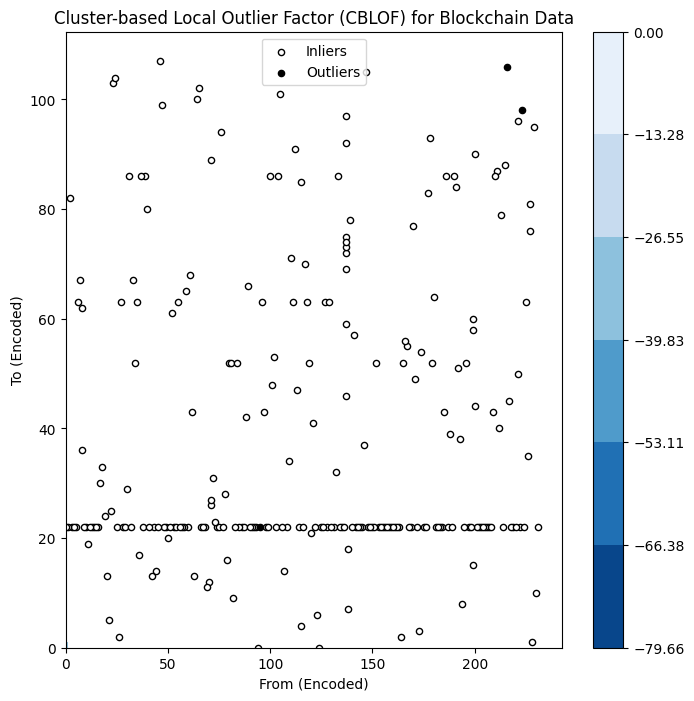

In [50]:
df = blockchain_data

# Convert hex values to label encoded numeric values
label_encoder = LabelEncoder()
df['From'] = label_encoder.fit_transform(df['From'])
df['To'] = label_encoder.fit_transform(df['To'])

# Select relevant columns for the analysis
selected_columns = ['From', 'To', 'Value (ETH)']
selected_data = df[selected_columns]

# Convert the DataFrame to a NumPy array
X = selected_data.values

# # Normalize the 'Value (ETH)' column to ensure a consistent scale for CBLOF
# X[:, -1] = (X[:, -1] - X[:, -1].min()) / (X[:, -1].max() - X[:, -1].min())

# Train CBLOF model
outliers_fraction = 0.01
clf = CBLOF(contamination=outliers_fraction, check_estimator=False, random_state=0)
clf.fit(X)

# Prediction
y_pred = clf.predict(X)
df['Anomaly'] = y_pred.tolist()

# Create a meshgrid for the contour plot
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

# Use decision_function on the original feature space (3D)
Z = clf.decision_function(X) * -1

Z_mesh = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]) * -1
Z_mesh = Z_mesh.reshape(xx.shape)

# Visualization
inliers = df[df['Anomaly'] == 0]
outliers = df[df['Anomaly'] == 1]

plt.figure(figsize=(8, 8))

# Plot filled contour plot
contour = plt.contourf(xx, yy, Z_mesh, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)

# Plot inliers
plt.scatter(inliers['From'], inliers['To'], color='white', edgecolor='k', s=20, label='Inliers')

# Plot outliers
plt.scatter(outliers['From'], outliers['To'], color='black', edgecolor='k', s=20, label='Outliers')

# Add colorbar
plt.colorbar(contour)

plt.title('Cluster-based Local Outlier Factor (CBLOF) for Blockchain Data')
plt.xlabel('From (Encoded)')
plt.ylabel('To (Encoded)')
plt.legend()
plt.show()